# AWS Public Blockchain - Cross-Chain Examples

In [3]:
pip install PyAthena


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import boto3
import pandas as pd
from pyathena import connect

In [10]:
S3_BUCKET=!(aws cloudformation list-exports --query "Exports[?Name=='public-blockchain-athena-results'].Value" --output text)
S3_BUCKET=S3_BUCKET[0]

In [11]:
conn = connect(s3_staging_dir='s3://'+S3_BUCKET+'/results/')

### Get number of blocks per chain

In [12]:
df = pd.read_sql("select 'BTC' as chain,count(*) as block_count from btc.blocks group by 'BTC' union select 'ETH' as chain,count(*) as block_count from eth.blocks group by 'ETH'", conn)
df

,chain,block_count
0,ETH,15607425
1,BTC,753866


### Get block number for time stamp

In [14]:
df = pd.read_sql("""(SELECT 'BTC' AS chain, number AS block, timestamp FROM btc.blocks WHERE 
  timestamp>=TIMESTAMP '2016-01-14 18:23 UTC' 
ORDER BY timestamp limit 1)
UNION (
SELECT 'ETH' AS chain, number AS block, timestamp FROM eth.blocks WHERE 
  timestamp>=TIMESTAMP '2016-01-14 18:23 UTC' 
ORDER BY timestamp limit 1)""", conn)
df

,chain,block,timestamp
0,ETH,848182,2016-01-14 18:23:13
1,BTC,393323,2016-01-14 19:10:58


## Charts

### Transactions per Second

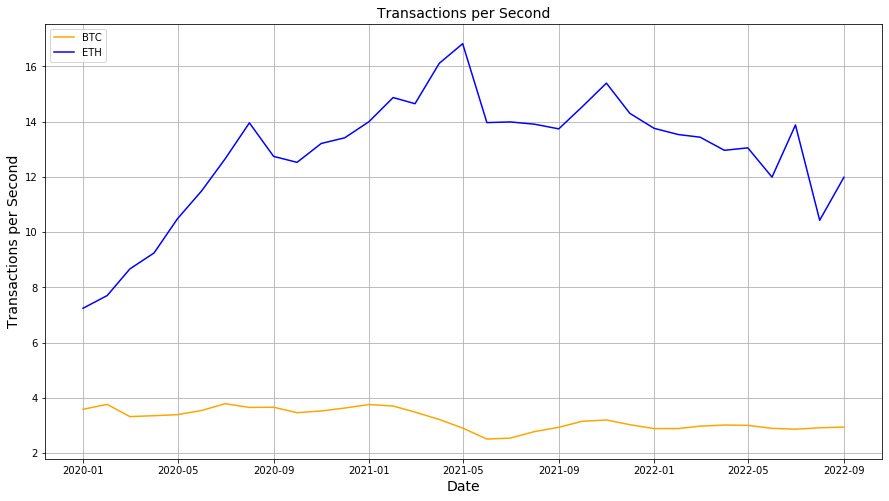

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_sql("""
with btc_transactions as (select date_trunc('month',cast(date as date)) as date, avg(transactions_per_sec) as transactions_per_sec from (
    select date, cast(count(*) as double)/(24*60*60) as transactions_per_sec
    from btc.transactions
    where date>='2020-01-01'
    group by date) group by  date_trunc('month',cast(date as date))),
    eth_transactions as (select date_trunc('month',cast(date as date)) as date, avg(transactions_per_sec) as transactions_per_sec from (
    select date, cast(count(*) as double)/(24*60*60) as transactions_per_sec
    from eth.transactions
    where date>='2020-01-01'
    group by date) group by  date_trunc('month',cast(date as date)))
select bt.date,bt.transactions_per_sec as tx_btc,et.transactions_per_sec as tx_eth from btc_transactions bt left join eth_transactions et on bt.date=et.date order by bt.date
""", conn)
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
del df['date']

plt.rcParams["figure.figsize"] = (15,8)
plt.plot(df.index, df['tx_btc'], color='orange', label="BTC")
plt.plot(df.index, df['tx_eth'], color='blue', label="ETH")
plt.title('Transactions per Second', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Transactions per Second', fontsize=14)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### Historical Price Data

Please note the following charts require market data loaded first. Please run through ***load-marketdata.ipynb*** notebook first.

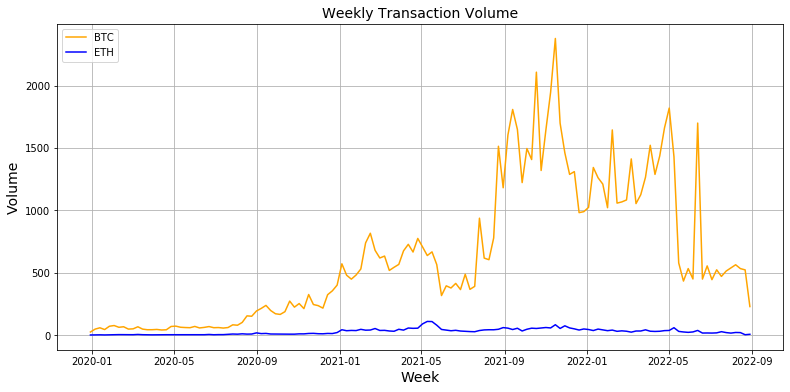

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_sql("""
WITH 
  daily_amt AS (SELECT cast(date AS date) AS date, sum(input_value) AS amt FROM btc.transactions where date>='2018-01-01' GROUP BY date),
  daily_price as (SELECT cast(open_time AS DATE) AS date, close AS price FROM marketdata.crypto where ticker='BTCUSDT' and extract(MINUTE FROM open_time)=59 and extract(HOUR FROM open_time)=23 and open_time >= TIMESTAMP '2020-01-01 00:00:00'),
  transaction_volume_btc as (SELECT date_trunc('week', date) AS week, sum(transaction_volume) / 1000000000 AS transaction_volume, avg(price) AS price FROM (SELECT A.date, B.amt * A.price AS transaction_volume, a.price FROM daily_price A JOIN daily_amt B ON A.date=B.date) GROUP BY date_trunc('week', date) ORDER BY date_trunc('week',date)),
  
  daily_amt_eth AS (SELECT cast(date AS date) AS date, sum(value/1000000000000000000) AS amt FROM eth.transactions where date>='2018-01-01' GROUP BY date),
  daily_price_eth as (SELECT cast(open_time AS DATE) AS date, close AS price FROM marketdata.crypto where ticker='ETHUSDT' and extract(MINUTE FROM open_time)=59 and extract(HOUR FROM open_time)=23 and open_time >= TIMESTAMP '2020-01-01 00:00:00'),
  transaction_volume_eth as (SELECT date_trunc('week', date) AS week, sum(transaction_volume) / 1000000000 AS transaction_volume, avg(price) AS price FROM (SELECT A.date, B.amt * A.price AS transaction_volume, a.price FROM daily_price_eth A JOIN daily_amt_eth B ON A.date=B.date) GROUP BY date_trunc('week', date) ORDER BY date_trunc('week',date))
  
  SELECT bt.week,bt.transaction_volume as transaction_volume_btc,et.transaction_volume as transaction_volume_eth from transaction_volume_btc bt left join transaction_volume_eth et on bt.week=et.week order by bt.week
""", conn)
df.set_index(pd.DatetimeIndex(df['week']),inplace=True)

plt.rcParams["figure.figsize"] = (13,6)
plt.plot(df.index, df['transaction_volume_btc'], color='orange', label="BTC")
plt.plot(df.index, df['transaction_volume_eth'], color='blue', label="ETH")
plt.title('Weekly Transaction Volume', fontsize=14)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()